In [1]:
import sys; sys.path.insert(0, "..")
from src.models import NLM, LUNA
from src.utils import generate_data, neg_log_likelihood, epistemic_uncertainty

In [2]:
from autograd import numpy as np
from autograd import grad
import matplotlib.pyplot as plt

In [3]:
# data generating funnctions
def f(x, y, noise_var = 1.):
    z = 10 * np.sin( 2 * np.sqrt(x ** 2 + y ** 2))
    z_noise = z + noise_var**0.5 * np.random.normal(size=z.shape)
    return z_noise

def f2(x, y, noise_var = 1.):
    z = x**3 + y**3
    z_noise = z + noise_var**0.5 * np.random.normal(size=z.shape)
    return z_noise

def f3(x, y, noise_var = 1.):
    z = 20 * ( np.sin(x) ** 10 + np.cos(10 + y * x) * np.cos(x) )
    z_noise = z + noise_var**0.5 * np.random.normal(size=z.shape)
    return z_noise


In [4]:
# Generate toy data
noise_var = 1.

# generate true contour
x1_true = np.linspace(-4, 4, 100)
x2_true = np.linspace(-4, 4, 100)

X1_true, X2_true = np.meshgrid(x1_true, x2_true)
Y_true = f(X1_true, X2_true, noise_var = 0.)

# generate x_train, y_train with a gap
x1_train = np.linspace(-3.25, 3.25, 30)
x2_train = np.linspace(-3.25, 3.25, 30)

X1, X2 = np.meshgrid(x1_train, x2_train)
gap_idx = np.logical_and(np.logical_and(X1 < 1.25, X1 > -1.25),np.logical_and(X2 < 1.25, X2 > -1.25))
Y = f(X1[~gap_idx],X2[~gap_idx], noise_var = noise_var)

x = np.stack((X1[~gap_idx].flatten(),X2[~gap_idx].flatten()))
y = Y.flatten().reshape(1,-1)
print(x.shape,y.shape)

# make a slice (with fixed value of x2 ~= 0)
x2_fixed_idx = np.argwhere(x2_train<0)[-1][0] # find the index for a value for x2 within the gap (closest to x2 ~= 0)
x2_fixed = x2_train[x2_fixed_idx] # extract the value of x2
x_train_idx = X2[~gap_idx] == x2_train[x2_fixed_idx] # identify the indices of training data on this slice
x_train_slice = X1[~gap_idx][x_train_idx] # identify the X1 values on the slice
y_train_slice = Y[x_train_idx] # identify the Y values on the slice

# generate x_test along the slice
x1_test = x1_true.copy()
x_test = np.stack((x1_test,x2_fixed*np.ones((x1_true.shape[0],))))
y_test_slice = f(x1_test,x2_fixed*np.ones((x1_true.shape[0],)), noise_var = 0.)

# generate x_test in gap and non-gap
test_gap_idx = np.logical_and(np.logical_and(X1_true < 1.25, X1_true > -1.25),np.logical_and(X2_true < 1.25, X2_true > -1.25))
test_non_gap_idx = np.logical_and(np.logical_and(np.logical_and(X1_true < 3.25, X1_true > -3.25), np.logical_and(X2_true < 3.25, X2_true > -3.25)), ~test_gap_idx)

x_test_gap = np.stack((X1_true[test_gap_idx].flatten(),X2_true[test_gap_idx].flatten()))
y_test_gap = Y_true[test_gap_idx].reshape(1,-1)

x_test_non_gap = np.stack((X1_true[test_non_gap_idx].flatten(),X2_true[test_non_gap_idx].flatten()))
y_test_non_gap = Y_true[test_non_gap_idx].reshape(1,-1)

(2, 756) (1, 756)


In [5]:
# # Generate toy data
# noise_var = 1.

# # generate true contour
# x1_true = np.linspace(-5, 5, 100)
# x2_true = np.linspace(-5, 5, 100)

# X1_true, X2_true = np.meshgrid(x1_true, x2_true)
# Y_true = f(X1_true, X2_true, noise_var = 0.)

# # generate x_train, y_train with a gap
# x1_train = np.linspace(-4.5, 4.5, 40)
# x2_train = np.linspace(-4.5, 4.5, 40)

# X1, X2 = np.meshgrid(x1_train, x2_train)
# gap_idx = np.logical_and(X1 < -1, X1 > -3.5)
# Y = f(X1[~gap_idx],X2[~gap_idx], noise_var = noise_var)

# x = np.stack((X1[~gap_idx].flatten(),X2[~gap_idx].flatten()))
# y = Y.flatten().reshape(1,-1)
# print(x.shape,y.shape)

# # make a slice (with fixed value of x2 ~= 0)
# x2_fixed_idx = np.argwhere(x2_train<0)[-1][0] # find the index for a value for x2 within the gap (closest to x2 ~= 0)
# x2_fixed = x2_train[x2_fixed_idx] # extract the value of x2
# x_train_idx = X2[~gap_idx] == x2_train[x2_fixed_idx] # identify the indices of training data on this slice
# x_train_slice = X1[~gap_idx][x_train_idx] # identify the X1 values on the slice
# y_train_slice = Y[x_train_idx] # identify the Y values on the slice

# # generate x_test
# x1_test = x1_true.copy()
# x_test = np.stack((x1_test,x2_fixed*np.ones((x1_true.shape[0],))))
# y_test_slice = f(x1_test,x2_fixed*np.ones((x1_true.shape[0],)), noise_var = 0.)

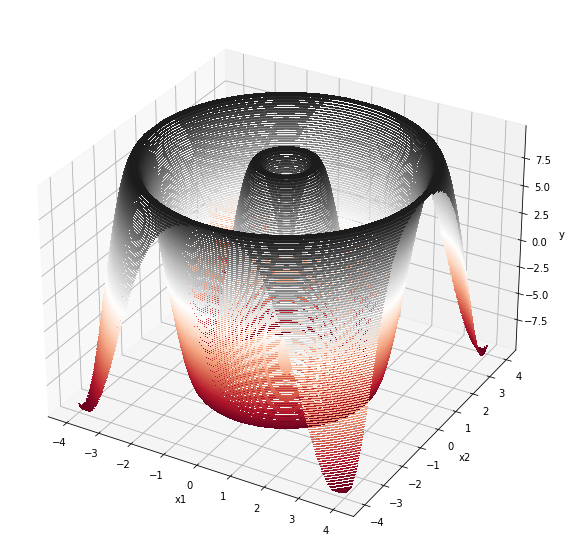

In [6]:
# Visualize ground truth of the function
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.contourf(X1_true, X2_true, Y_true, 100, cmap='RdGy')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.show()

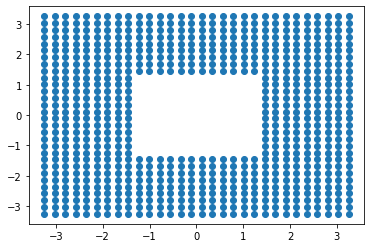

In [7]:
# plot x-y coordinate for training samples (with a gap)
plt.scatter(x[0,:],x[1,:])

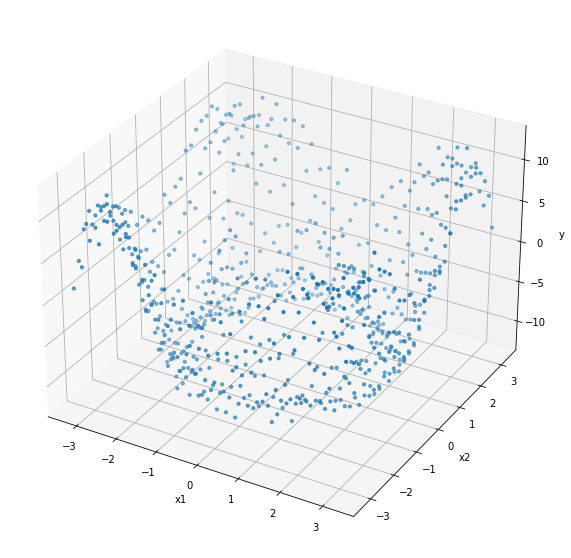

In [8]:
# Visualize training data
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(x[0,:],x[1,:],y.flatten(), s = 10)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.show()

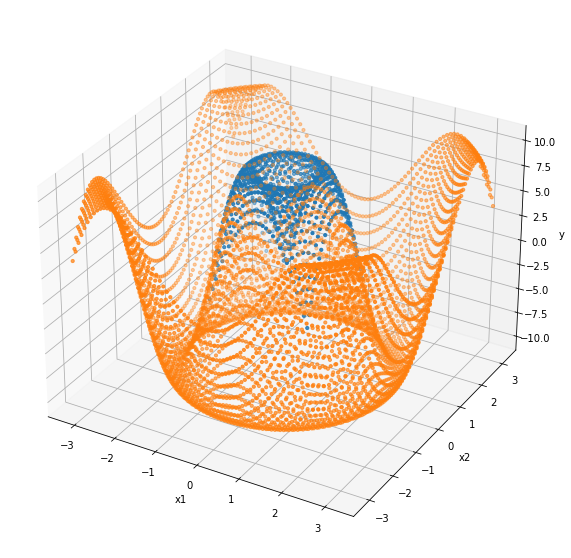

In [9]:
# Visualize test data (gap and non-gap)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(x_test_gap[0,:],x_test_gap[1,:],y_test_gap.flatten(), s = 10)
ax.scatter(x_test_non_gap[0,:],x_test_non_gap[1,:],y_test_non_gap.flatten(), s = 10)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.show()


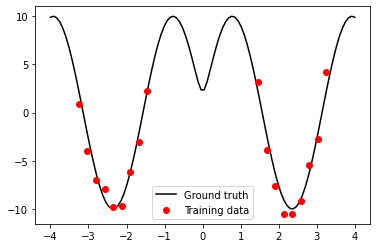

In [10]:
# visualize a slice over the 2-D function
plt.scatter(x_train_slice,y_train_slice,color='r',zorder = 100,label='Training data')
plt.plot(x_test[0,:],y_test_slice,'k',label='Ground truth')
plt.legend()
plt.show()

## LUNA

In [11]:
# relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

width = [50,50] # using the architecture used in the paper
hidden_layers = len(width)
input_dim = 2
output_dim = 1

architecture = {
    'width': width,
    'input_dim': input_dim,
    'output_dim': output_dim,
    'activation_fn_type': 'relu',
    'activation_fn_params': 'rate=1',
    'activation_fn': activation_fn,
    'auxiliary_functions': 50,
}

#set random state to make the experiments replicable
rand_state = 207
random = np.random.RandomState(rand_state)

#instantiate a NN with LUNA
luna = LUNA(architecture, random=random)
print('Number of parameters =',luna.D)

Number of parameters = 5250


### Inspect coSim^2 before fitting

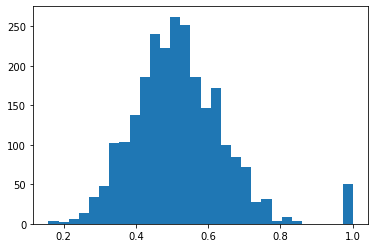

In [12]:
grad_FD = luna._finite_diff_grad(luna.weights, x) # M x dim_in x num of samples
norm_grad = grad_FD/(np.linalg.norm(grad_FD, axis = 1, keepdims=True)) # normalize along gradient wrt dim_in to unit length
norm_grad_transpose = np.transpose(norm_grad,(1,0,2)) # transpose first two dimensions of norm_grad
coSimSqMat = np.mean(np.einsum('ij...,jk...->ik...', norm_grad, norm_grad_transpose)**2, axis = -1) # take pairwise square cosine similarity between auxiliary functions, average over datapoints

plt.hist(coSimSqMat.flatten(),bins=30)
plt.show()

### Inspect auxiliary functions before fitting

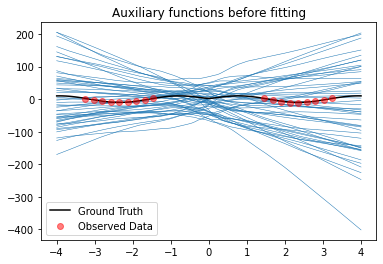

In [13]:
y_pred = luna.forward(luna.weights, x_test)
plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x1_test.T, np.squeeze(y_pred).T,linewidth = 0.5, alpha=1, zorder = 0,color='tab:blue')
plt.title('Auxiliary functions before fitting')
plt.legend()
plt.show()

### Fit LUNA

In [14]:
### define design choices in gradient descent

params = {
    'step_size':1e-2,
    'max_iteration':2000,
    'random_restarts':1,
    'reg_param':10.,
    'lambda_in':10.,
}

# fit LUNA
luna.fit(x, y, params)

Iteration 0 loss 8046.180227335176; gradient mag: 3479.8765665744163
Iteration 100 loss 77.77973878372045; gradient mag: 21.220797493458036
Iteration 200 loss 45.62444350160295; gradient mag: 8.50815711776852
Iteration 300 loss 36.2873718060715; gradient mag: 5.229519563135156
Iteration 400 loss 32.53413500906811; gradient mag: 4.195539178390135
Iteration 500 loss 30.352772117914828; gradient mag: 5.142037185542576
Iteration 600 loss 28.740803729258037; gradient mag: 5.569017556560422
Iteration 700 loss 27.20263052709825; gradient mag: 4.758165867947536
Iteration 800 loss 26.030537356536946; gradient mag: 4.794057459947983
Iteration 900 loss 25.106544639808888; gradient mag: 4.8477259447250205
Iteration 1000 loss 24.363446829546817; gradient mag: 8.515191444377587
Iteration 1100 loss 23.694429029215403; gradient mag: 6.28350125806896
Iteration 1200 loss 23.36961908263965; gradient mag: 13.976029548641279
Iteration 1300 loss 22.968722372014263; gradient mag: 9.848706981346076
Iteration 

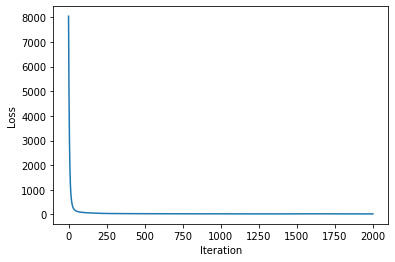

In [15]:
plt.plot(luna.objective_trace)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

### Inspect coSim^2 after fitting

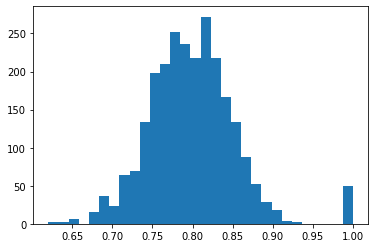

In [16]:
grad_FD = luna._finite_diff_grad(luna.weights, x) # M x dim_in x num of samples
norm_grad = grad_FD/(np.linalg.norm(grad_FD, axis = 1, keepdims=True)) # normalize along gradient wrt dim_in to unit length
norm_grad_transpose = np.transpose(norm_grad,(1,0,2)) # transpose first two dimensions of norm_grad
coSimSqMat = np.mean(np.einsum('ij...,jk...->ik...', norm_grad, norm_grad_transpose)**2, axis = -1) # take pairwise square cosine similarity between auxiliary functions, average over datapoints

plt.hist(coSimSqMat.flatten(),bins=30);

### Inspect auxiliary functions after fitting

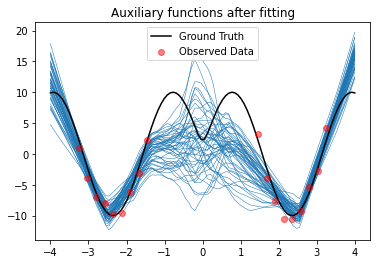

In [17]:
y_pred = luna.forward(luna.weights, x_test)
plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x1_test.T, np.squeeze(y_pred).T,linewidth = 0.5, alpha=1, zorder = 0,color='tab:blue')
plt.title('Auxiliary functions after fitting')
plt.legend()
plt.show()

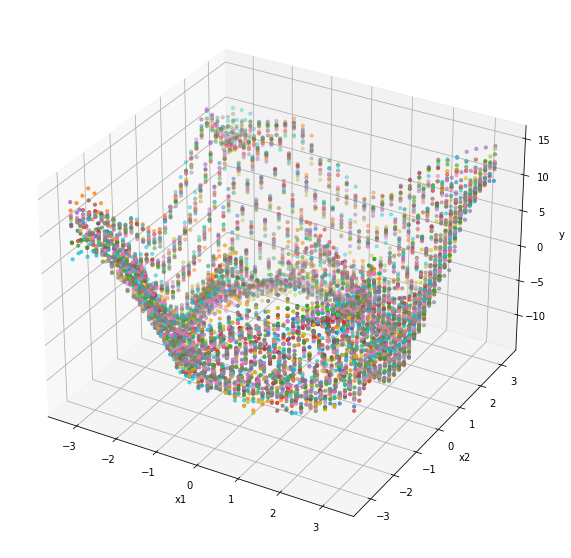

In [18]:
y_pred = luna.forward(luna.weights, x)
y_pred.shape

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

for i in range(10):    
    ax.scatter(X1[~gap_idx],X2[~gap_idx], y_pred[i,0,:], s=10)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.show()

### Display prior samples

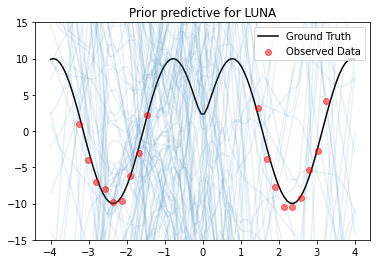

In [19]:
prior_mean = 0
prior_var = 25.
# noise_var = 9.
y_prior = luna.get_prior_preds(x_test, w_prior_mean=prior_mean, w_prior_cov=prior_var, noise_var=noise_var)

plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")

plt.plot(x_test[0,:], y_prior.T, color='tab:blue', alpha=0.1)
plt.ylim([-15, 15])
# plt.ylim([-150, 150])
plt.title('Prior predictive for LUNA')
plt.legend()
plt.show()

### Display posterior samples

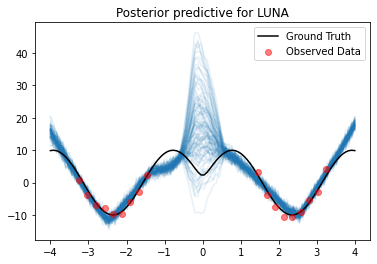

In [20]:
y_posterior = luna.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")

plt.plot(x_test[0,:], y_posterior.T, zorder = 0,color='tab:blue', alpha=0.1)
plt.title('Posterior predictive for LUNA')
plt.legend()
plt.show()

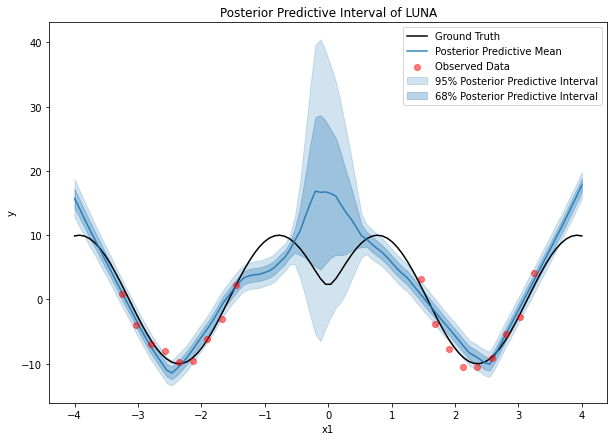

In [21]:
# Calulating percentiles
y_posterior = luna.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

pp_upper = np.percentile(y_posterior, 97.5, axis=0)
pp_lower = np.percentile(y_posterior, 2.5, axis=0)
pp_upper2 = np.percentile(y_posterior, 84, axis=0)
pp_lower2 = np.percentile(y_posterior, 16, axis=0)
pp_mean = np.mean(y_posterior, axis=0)

# Visualizing 95% posterior predictive interval of Bayesian polynomial regression
plt.figure(figsize=(10,7))
plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x_test[0,:], pp_mean, color='tab:blue', alpha=0.9, label='Posterior Predictive Mean')
plt.fill_between(x_test[0,:], pp_upper, pp_lower, color='tab:blue', alpha=0.2, label='95% Posterior Predictive Interval')
plt.fill_between(x_test[0,:], pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3, label = '68% Posterior Predictive Interval')
plt.legend()
plt.xlabel('x1')
plt.ylabel('y')
plt.title("Posterior Predictive Interval of LUNA")
plt.show()

In [22]:
# Compute neg_log_likelihood and epistemic uncertainty on training data
y_posterior = luna.get_posterior_preds(x, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

print('Negative log likelihood on training data =', neg_log_likelihood(y_posterior, y, noise_var))
print('epistemic uncertainty on training data = ', epistemic_uncertainty(y_posterior))

Negative log likelihood on training data = 2.47169131065953
epistemic uncertainty on training data =  1.0275266579449904


In [23]:
# Compute neg_log_likelihood and epistemic uncertainty on test data (gap vs. non-gap)
y_posterior_gap = luna.get_posterior_preds(x_test_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior_gap = y_posterior_gap + np.random.normal(0, noise_var**0.5, size = y_posterior_gap.shape)


y_posterior_non_gap = luna.get_posterior_preds(x_test_non_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior_non_gap = y_posterior_non_gap + np.random.normal(0, noise_var**0.5, size = y_posterior_non_gap.shape)


print('Negative log likelihood on test data (gap) =', neg_log_likelihood(y_posterior_gap, y_test_gap, noise_var))
print('Epistemic uncertainty on test data (gap) = ', epistemic_uncertainty(y_posterior_gap))

print('Negative log likelihood on test data (non-gap) =', neg_log_likelihood(y_posterior_non_gap, y_test_non_gap, noise_var))
print('Epistemic uncertainty on test data (non-gap) = ', epistemic_uncertainty(y_posterior_non_gap))

Negative log likelihood on test data (gap) = 20.40088048515857
Epistemic uncertainty on test data (gap) =  2.5239104503510568
Negative log likelihood on test data (non-gap) = 2.1212014437790234
Epistemic uncertainty on test data (non-gap) =  1.027715528847265


## NLM

In [24]:
# instantiate an NLM with same architecture 
nlm = NLM(architecture, random=random)
print('Number of parameters =', nlm.D)

# params = {
#     'step_size':1e-2,
#     'max_iteration':2000,
#     'random_restarts':1,
#     'reg_param':10.
# }

nlm.fit(x,y, params)

Number of parameters = 2751
Iteration 0 loss 2542.4074255809223; gradient mag: 7349.577513581415
Iteration 100 loss 26.11571976771237; gradient mag: 18.705870941774364
Iteration 200 loss 20.459259960844594; gradient mag: 18.6411300628758
Iteration 300 loss 14.914321630277712; gradient mag: 14.25181820912051
Iteration 400 loss 13.510030437549503; gradient mag: 21.61881338951668
Iteration 500 loss 12.772157076803456; gradient mag: 23.50307031425708
Iteration 600 loss 12.318325565869547; gradient mag: 37.80294401780317
Iteration 700 loss 11.940489869408738; gradient mag: 4.4974339654705675
Iteration 800 loss 11.70716525980099; gradient mag: 30.769401840183853
Iteration 900 loss 11.47533476818889; gradient mag: 23.412963642579165
Iteration 1000 loss 11.298095514412323; gradient mag: 43.20758072204035
Iteration 1100 loss 11.033639588864503; gradient mag: 5.332086352514742
Iteration 1200 loss 10.895243766632216; gradient mag: 44.44689625681807
Iteration 1300 loss 10.656996469620024; gradient

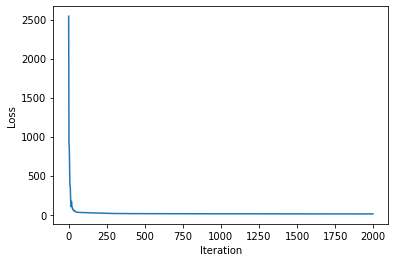

In [25]:
plt.plot(nlm.objective_trace)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

### Inspect MLE fit

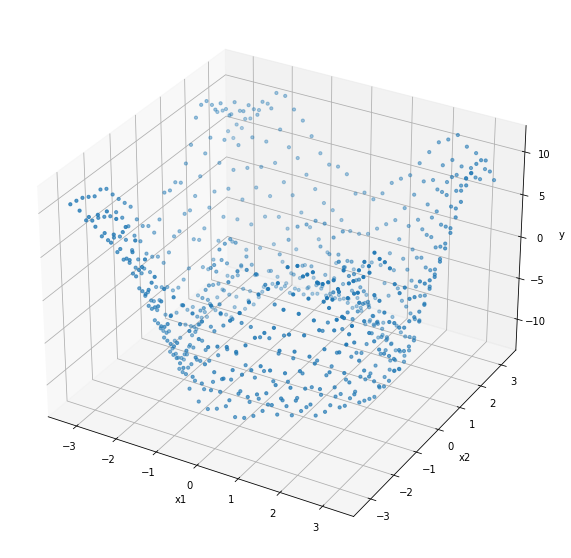

In [26]:
y_pred = nlm.forward(nlm.weights, x)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(X1[~gap_idx],X2[~gap_idx], y_pred.flatten(), s=10)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.show()

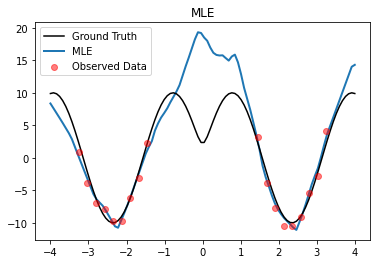

In [27]:
y_pred = nlm.forward(nlm.weights, x_test)
plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x1_test.T, np.squeeze(y_pred).T,linewidth = 2, alpha=1, zorder = 0,color='tab:blue',label='MLE')
plt.title('MLE')
plt.legend()
plt.show()

### Display prior samples

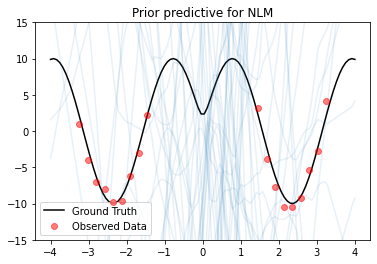

In [28]:
prior_mean = 0
prior_var = 9.
# noise_var = 9.
y_prior = nlm.get_prior_preds(x_test, w_prior_mean=prior_mean, w_prior_cov=prior_var, noise_var=noise_var)

plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x_test[0,:], y_prior.T, color='tab:blue', alpha=0.1)
plt.ylim([-15, 15])
# plt.ylim([-150, 150])
plt.title('Prior predictive for NLM')
plt.legend()
plt.show()

### Display posterior samples

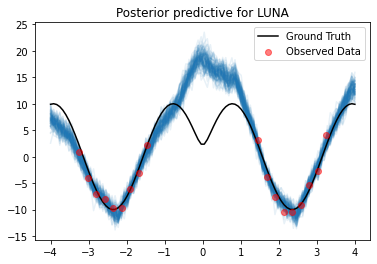

In [29]:
y_posterior = nlm.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape) 

plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")

plt.plot(x_test[0,:], y_posterior.T, color='tab:blue', alpha=0.1,zorder=0)
plt.title('Posterior predictive for NLM')
plt.legend()
plt.show()

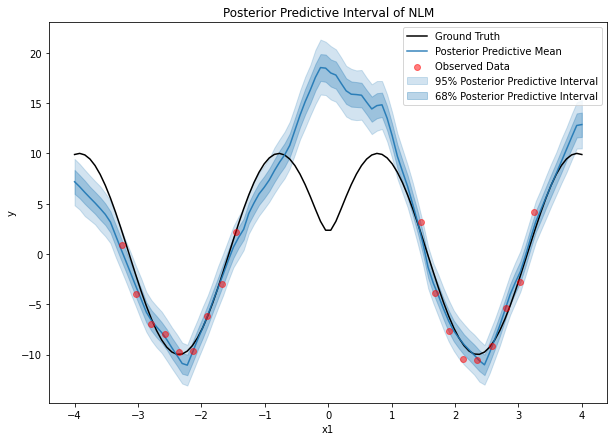

In [30]:
# Calulating percentiles
y_posterior = nlm.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

pp_upper = np.percentile(y_posterior, 97.5, axis=0)
pp_lower = np.percentile(y_posterior, 2.5, axis=0)
pp_upper2 = np.percentile(y_posterior, 84, axis=0)
pp_lower2 = np.percentile(y_posterior, 16, axis=0)
pp_mean = np.mean(y_posterior, axis=0)

# Visualizing 95% posterior predictive interval of Bayesian polynomial regression
plt.figure(figsize=(10,7))
plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x_test[0,:], pp_mean, color='tab:blue', alpha=0.9, label='Posterior Predictive Mean')
plt.fill_between(x_test[0,:], pp_upper, pp_lower, color='tab:blue', alpha=0.2, label='95% Posterior Predictive Interval')
plt.fill_between(x_test[0,:], pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3, label = '68% Posterior Predictive Interval')
plt.legend()
plt.xlabel('x1')
plt.ylabel('y')
plt.title("Posterior Predictive Interval of NLM")
plt.show()

In [31]:
# Compute neg_log_likelihood and epistemic uncertainty on training data
y_posterior = nlm.get_posterior_preds(x, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

print('Negative log likelihood on training data =', neg_log_likelihood(y_posterior, y, noise_var))
print('Epistemic uncertainty on training data = ', epistemic_uncertainty(y_posterior))

Negative log likelihood on training data = 2.1249088557277904
Epistemic uncertainty on training data =  1.0312538855243565


In [32]:
# Compute neg_log_likelihood and epistemic uncertainty on test data (gap vs. non-gap)
y_posterior_gap = nlm.get_posterior_preds(x_test_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior_gap = y_posterior_gap + np.random.normal(0, noise_var**0.5, size = y_posterior_gap.shape)


y_posterior_non_gap = nlm.get_posterior_preds(x_test_non_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior_non_gap = y_posterior_non_gap + np.random.normal(0, noise_var**0.5, size = y_posterior_non_gap.shape)


print('Negative log likelihood on test data (gap) =', neg_log_likelihood(y_posterior_gap, y_test_gap, noise_var))
print('Epistemic uncertainty on test data (gap) = ', epistemic_uncertainty(y_posterior_gap))

print('Negative log likelihood on test data (non-gap) =', neg_log_likelihood(y_posterior_non_gap, y_test_non_gap, noise_var))
print('Epistemic uncertainty on test data (non-gap) = ', epistemic_uncertainty(y_posterior_non_gap))

Negative log likelihood on test data (gap) = 17.874130888860694
Epistemic uncertainty on test data (gap) =  1.1882042976153535
Negative log likelihood on test data (non-gap) = 1.9275054521176191
Epistemic uncertainty on test data (non-gap) =  1.0308004835861164


# Repeat experiments with a different function


In [78]:
# generate toy data
noise_var = 9.

# generate true contour
x1_true = np.linspace(-5., 5., 100)
x2_true = np.linspace(-5., 5., 100)

X1_true, X2_true = np.meshgrid(x1_true, x2_true)
Y_true = f2(X1_true, X2_true, noise_var = 0.)

# generate x_train, y_train with a gap
x1_train = np.linspace(-4., 4., 30)
x2_train = np.linspace(-4., 4., 30)

X1, X2 = np.meshgrid(x1_train, x2_train)
gap_idx = np.logical_and(np.logical_and(X1 < 2., X1 > -2.), np.logical_and(X2 < 2., X2 > -2.))
# gap_idx = np.logical_and(X1 < 2., X1 > -2.)
# gap_idx = (X1**2 + X2**2)**(0.5) < 2.
Y = f2(X1[~gap_idx],X2[~gap_idx], noise_var = noise_var)

x = np.stack((X1[~gap_idx].flatten(),X2[~gap_idx].flatten()))
y = Y.flatten().reshape(1,-1)
print(x.shape,y.shape)

# make a slice (with fixed value of x2 ~= 0)
x2_fixed_idx = np.argwhere(x2_train<0)[-1][0] # find the index for a value for x2 within the gap (closest to x2 ~= 0)
x2_fixed = x2_train[x2_fixed_idx] # extract the value of x2
x_train_idx = X2[~gap_idx] == x2_train[x2_fixed_idx] # identify the indices of training data on this slice
x_train_slice = X1[~gap_idx][x_train_idx] # identify the X1 values on the slice
y_train_slice = Y[x_train_idx] # identify the Y values on the slice

# generate x_test
x1_test = x1_true.copy()
x_test = np.stack((x1_test,x2_fixed*np.ones((x1_true.shape[0],))))
y_test_slice = f2(x1_test,x2_fixed*np.ones((x1_true.shape[0],)), noise_var = 0.)

# generate x_test in gap and non-gap
test_gap_idx = np.logical_and(np.logical_and(X1_true < 1.25, X1_true > -1.25),np.logical_and(X2_true < 1.25, X2_true > -1.25))
test_non_gap_idx = np.logical_and(np.logical_and(np.logical_and(X1_true < 3.25, X1_true > -3.25), np.logical_and(X2_true < 3.25, X2_true > -3.25)), ~test_gap_idx)

x_test_gap = np.stack((X1_true[test_gap_idx].flatten(),X2_true[test_gap_idx].flatten()))
y_test_gap = Y_true[test_gap_idx].reshape(1,-1)

x_test_non_gap = np.stack((X1_true[test_non_gap_idx].flatten(),X2_true[test_non_gap_idx].flatten()))
y_test_non_gap = Y_true[test_non_gap_idx].reshape(1,-1)

(2, 704) (1, 704)


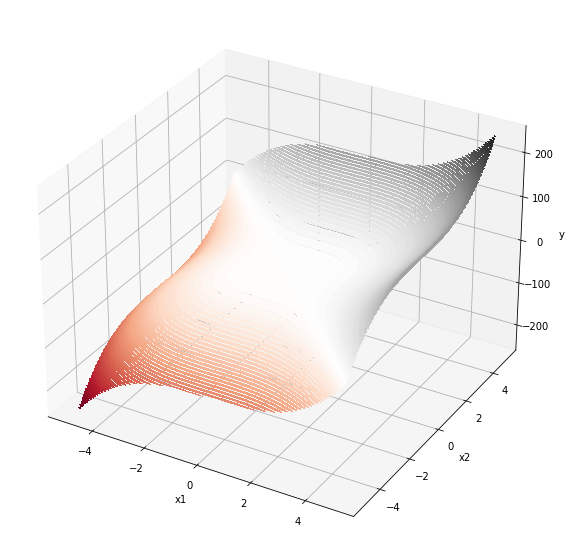

In [79]:
# Visualize ground truth of the function
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.contourf(X1_true, X2_true, Y_true, 100, cmap='RdGy')
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.show()

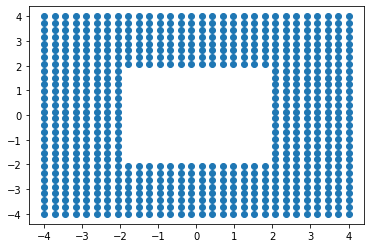

In [80]:
# plot x-y coordinate for training samples (with a gap)
plt.scatter(x[0,:],x[1,:])
plt.show()

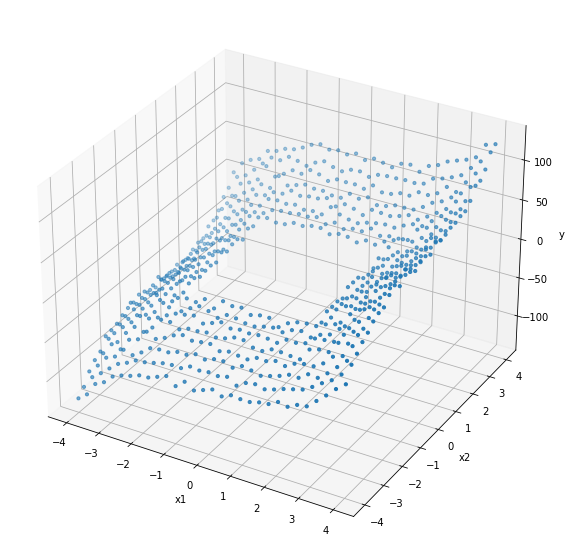

In [81]:
# Visualize training data
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(x[0,:],x[1,:],y.flatten(), s = 10)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.show()

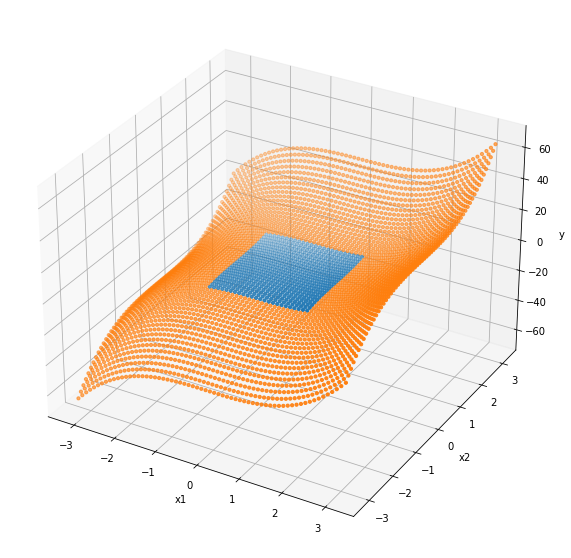

In [82]:
# Visualize test data (gap and non-gap)
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(x_test_gap[0,:],x_test_gap[1,:],y_test_gap.flatten(), s = 10)
ax.scatter(x_test_non_gap[0,:],x_test_non_gap[1,:],y_test_non_gap.flatten(), s = 10)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.show()

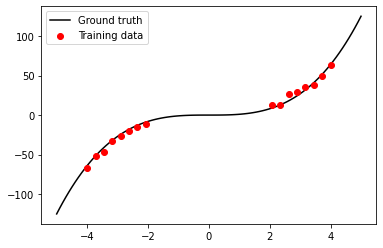

In [83]:
# visualize a slice over the 2-D function
plt.scatter(x_train_slice,y_train_slice,color='r',zorder = 100,label='Training data')
plt.plot(x_test[0,:],y_test_slice,'k',label='Ground truth')
plt.legend()
plt.show()

## LUNA

In [84]:
# relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)

width = [50,50] # using the architecture used in the paper
hidden_layers = len(width)
input_dim = 2
output_dim = 1

architecture = {
    'width': width,
    'input_dim': input_dim,
    'output_dim': output_dim,
    'activation_fn_type': 'relu',
    'activation_fn_params': 'rate=1',
    'activation_fn': activation_fn,
    'auxiliary_functions': 50,
}

# set random state to make the experiments replicable
rand_state = 207
random = np.random.RandomState(rand_state)

# instantiate a NN with LUNA
luna = LUNA(architecture, random=random)
print('Number of parameters =',luna.D)

Number of parameters = 5250


### Inspect coSim^2 before fitting

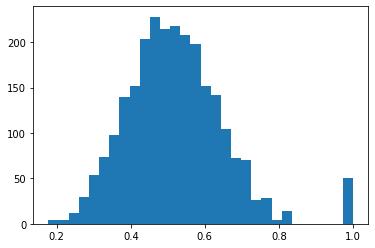

In [85]:
grad_FD = luna._finite_diff_grad(luna.weights, x) # M x dim_in x num of samples
norm_grad = grad_FD/(np.linalg.norm(grad_FD, axis = 1, keepdims=True)) # normalize along gradient wrt dim_in to unit length
norm_grad_transpose = np.transpose(norm_grad,(1,0,2)) # transpose first two dimensions of norm_grad
coSimSqMat = np.mean(np.einsum('ij...,jk...->ik...', norm_grad, norm_grad_transpose)**2, axis = -1) # take pairwise square cosine similarity between auxiliary functions, average over datapoints

plt.hist(coSimSqMat.flatten(),bins=30)
plt.show()

### Inspect auxiliary functions before fitting

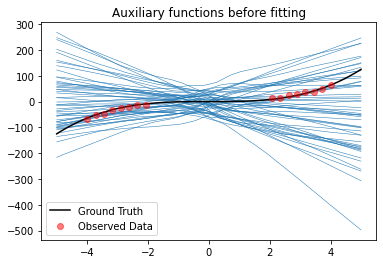

In [86]:
y_pred = luna.forward(luna.weights, x_test)
plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x1_test.T, np.squeeze(y_pred).T,linewidth = 0.5, alpha=1, zorder = 0,color='tab:blue')
plt.title('Auxiliary functions before fitting')
plt.legend()
plt.show()

### Fit LUNA

In [87]:
### define design choices in gradient descent
params = {
    'step_size':1e-2,
    'max_iteration':2000,
    'random_restarts':1,
    'reg_param':10.,
    'lambda_in':10000., # 300
}

# fit LUNA
luna.fit(x, y, params)

Iteration 0 loss 19551.073819618166; gradient mag: 5514.242923975049
Iteration 100 loss 5620.624187749777; gradient mag: 507.7532532341115
Iteration 200 loss 5407.615846500406; gradient mag: 158.3777658186213
Iteration 300 loss 5358.606414294183; gradient mag: 247.69737120299558
Iteration 400 loss 5314.473428508062; gradient mag: 274.4544023323665
Iteration 500 loss 5296.08229252168; gradient mag: 210.48084569451495
Iteration 600 loss 5280.731685357634; gradient mag: 277.20894300748375
Iteration 700 loss 5257.065372037683; gradient mag: 203.1829699907824
Iteration 800 loss 5258.266846726911; gradient mag: 237.24015623633676
Iteration 900 loss 5251.114330122022; gradient mag: 188.64210106496162
Iteration 1000 loss 5243.784172616284; gradient mag: 358.15737779079706
Iteration 1100 loss 5224.628262410438; gradient mag: 182.6537668801295
Iteration 1200 loss 5215.743790673241; gradient mag: 204.14016985705626
Iteration 1300 loss 5210.832202381268; gradient mag: 349.3183659394278
Iteration 1

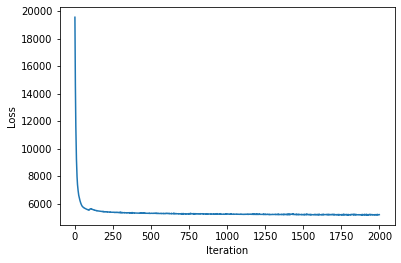

In [88]:
plt.plot(luna.objective_trace)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

### Inspect coSim^2 after fitting

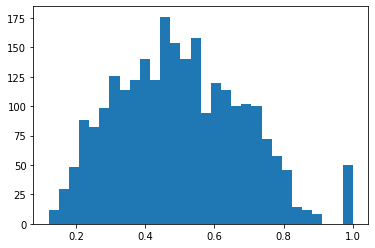

In [89]:
grad_FD = luna._finite_diff_grad(luna.weights, x) # M x dim_in x num of samples
norm_grad = grad_FD/(np.linalg.norm(grad_FD, axis = 1, keepdims=True)) # normalize along gradient wrt dim_in to unit length
norm_grad_transpose = np.transpose(norm_grad,(1,0,2)) # transpose first two dimensions of norm_grad
coSimSqMat = np.mean(np.einsum('ij...,jk...->ik...', norm_grad, norm_grad_transpose)**2, axis = -1) # take pairwise square cosine similarity between auxiliary functions, average over datapoints

plt.hist(coSimSqMat.flatten(),bins=30)
plt.show()

### Inspect auxiliary functions after fitting

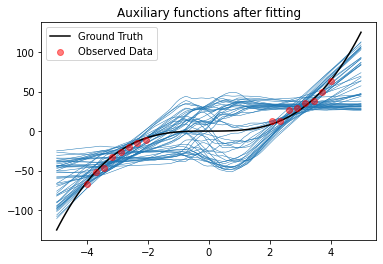

In [90]:
y_pred = luna.forward(luna.weights, x_test)
plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x1_test.T, np.squeeze(y_pred).T,linewidth = 0.5, alpha=1, zorder = 0,color='tab:blue')
plt.title('Auxiliary functions after fitting')
plt.legend()
plt.show()

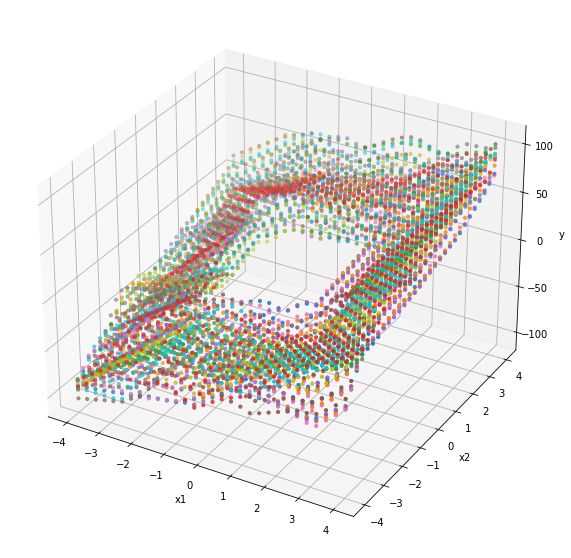

In [91]:
y_pred = luna.forward(luna.weights, x)
y_pred.shape

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')

for i in range(10):    
    ax.scatter(X1[~gap_idx],X2[~gap_idx], y_pred[i,0,:], s=10)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.show()

### Display prior samples

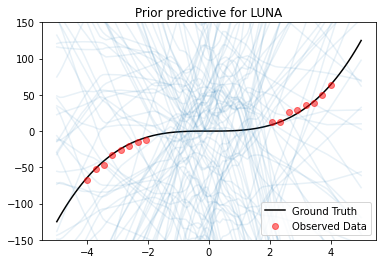

In [92]:
prior_mean = 0
prior_var = 25.
# noise_var = 9.
y_prior = luna.get_prior_preds(x_test, w_prior_mean=prior_mean, w_prior_cov=prior_var, noise_var=noise_var)

plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")

plt.plot(x_test[0,:], y_prior.T, color='tab:blue', alpha=0.1)
plt.ylim([-150, 150])
plt.title('Prior predictive for LUNA')
plt.legend()
plt.show()

### Display posterior samples

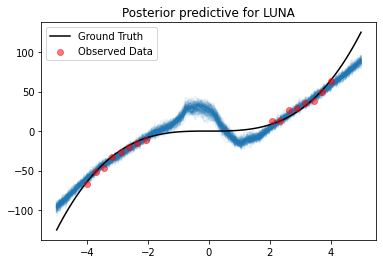

In [93]:
y_posterior = luna.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")

plt.plot(x_test[0,:], y_posterior.T, zorder = 0,color='tab:blue', alpha=0.1)
plt.title('Posterior predictive for LUNA')
plt.legend()
plt.show()

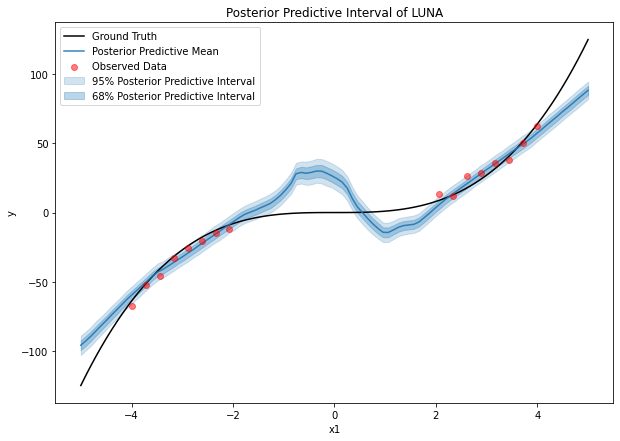

In [94]:
# Calulating percentiles
y_posterior = luna.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

pp_upper = np.percentile(y_posterior, 97.5, axis=0)
pp_lower = np.percentile(y_posterior, 2.5, axis=0)
pp_upper2 = np.percentile(y_posterior, 84, axis=0)
pp_lower2 = np.percentile(y_posterior, 16, axis=0)
pp_mean = np.mean(y_posterior, axis=0)

# Visualizing 95% posterior predictive interval of Bayesian polynomial regression
plt.figure(figsize=(10,7))
plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x_test[0,:], pp_mean, color='tab:blue', alpha=0.9, label='Posterior Predictive Mean')
plt.fill_between(x_test[0,:], pp_upper, pp_lower, color='tab:blue', alpha=0.2, label='95% Posterior Predictive Interval')
plt.fill_between(x_test[0,:], pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3, label = '68% Posterior Predictive Interval')
plt.legend()
plt.xlabel('x1')
plt.ylabel('y')
plt.title("Posterior Predictive Interval of LUNA")
plt.show()

In [95]:
# Compute neg_log_likelihood and epistemic uncertainty on training data
y_posterior = luna.get_posterior_preds(x, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

print('Negative log likelihood on training data =', neg_log_likelihood(y_posterior, y, noise_var))
print('Epistemic uncertainty on training data = ', epistemic_uncertainty(y_posterior))

Negative log likelihood on training data = 7.887069665489107
Epistemic uncertainty on training data =  3.0835896012585704


In [96]:
# Compute neg_log_likelihood and epistemic uncertainty on test data (gap vs. non-gap)
y_posterior_gap = nlm.get_posterior_preds(x_test_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior_gap = y_posterior_gap + np.random.normal(0, noise_var**0.5, size = y_posterior_gap.shape)


y_posterior_non_gap = nlm.get_posterior_preds(x_test_non_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior_non_gap = y_posterior_non_gap + np.random.normal(0, noise_var**0.5, size = y_posterior_non_gap.shape)


print('Negative log likelihood on test data (gap) =', neg_log_likelihood(y_posterior_gap, y_test_gap, noise_var))
print('Epistemic uncertainty on test data (gap) = ', epistemic_uncertainty(y_posterior_gap))

print('Negative log likelihood on test data (non-gap) =', neg_log_likelihood(y_posterior_non_gap, y_test_non_gap, noise_var))
print('Epistemic uncertainty on test data (non-gap) = ', epistemic_uncertainty(y_posterior_non_gap))

Negative log likelihood on test data (gap) = 18.62851243875713
Epistemic uncertainty on test data (gap) =  3.8729351669977907
Negative log likelihood on test data (non-gap) = 4.45130647028069
Epistemic uncertainty on test data (non-gap) =  3.1309195499077966


## NLM

### One can try NLM on this function with no regularization. I think even without regularization, we'll see no epistemic uncertainty in the gap.

In [52]:
# instantiate an NLM with same architecture 
nlm = NLM(architecture, random=random)
print('Number of parameters =', nlm.D)

# params = {
#     'step_size':1e-2,
#     'max_iteration':2000,
#     'random_restarts':1,
#     'reg_param':0.
# }

nlm.fit(x,y, params)

Number of parameters = 2751
Iteration 0 loss 5773.140518948214; gradient mag: 16141.475567215815
Iteration 100 loss 76.97614369886283; gradient mag: 72.13911462738771
Iteration 200 loss 30.830452371639666; gradient mag: 14.151373092222352
Iteration 300 loss 24.618591228106496; gradient mag: 10.680179732608998
Iteration 400 loss 21.43090291234484; gradient mag: 6.5167765928826755
Iteration 500 loss 20.40052060233523; gradient mag: 10.770452183649342
Iteration 600 loss 19.868389426525823; gradient mag: 5.297121148664058
Iteration 700 loss 19.470279761026113; gradient mag: 10.181661947555396
Iteration 800 loss 19.1322147844109; gradient mag: 14.513297929741258
Iteration 900 loss 18.833484437089556; gradient mag: 6.075229894019934
Iteration 1000 loss 18.593754994601845; gradient mag: 7.084016580365072
Iteration 1100 loss 18.385791647225275; gradient mag: 6.405607313359085
Iteration 1200 loss 18.20525569800906; gradient mag: 13.608645925368275
Iteration 1300 loss 18.02777448068521; gradient

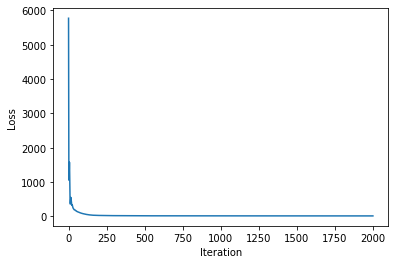

In [53]:
plt.plot(nlm.objective_trace)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

### Inspect MLE fit

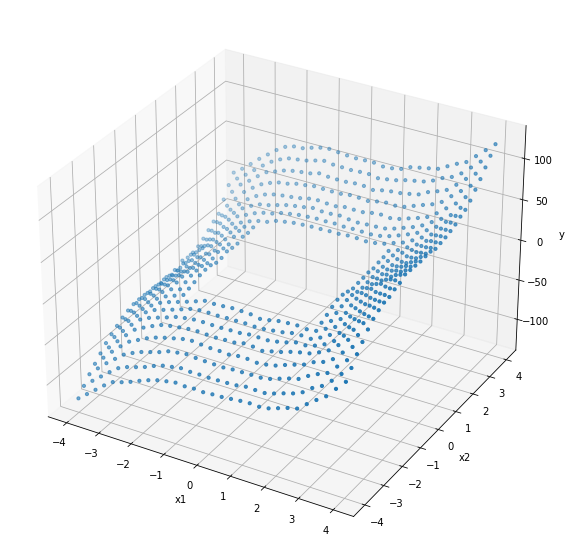

In [54]:
y_pred = nlm.forward(nlm.weights, x)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter(X1[~gap_idx],X2[~gap_idx], y_pred.flatten(), s=10)
ax.set_xlabel('x1')
ax.set_ylabel('x2')
ax.set_zlabel('y')
plt.show()

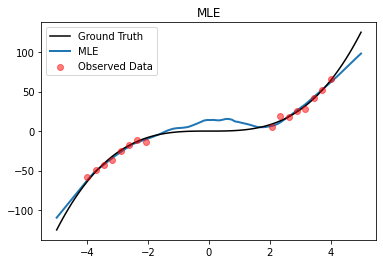

In [55]:
y_pred = nlm.forward(nlm.weights, x_test)
plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x1_test.T, np.squeeze(y_pred).T,linewidth = 2, alpha=1, zorder = 0,color='tab:blue',label='MLE')
plt.title('MLE')
plt.legend()
plt.show()

### Display prior samples

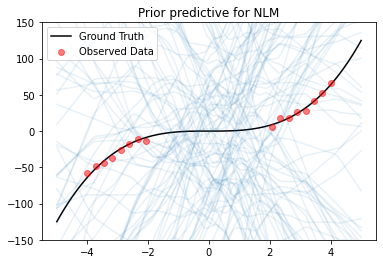

In [56]:
prior_mean = 0
prior_var = 25.
# noise_var = 9.
y_prior = nlm.get_prior_preds(x_test, w_prior_mean=prior_mean, w_prior_cov=prior_var, noise_var=noise_var)

plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x_test[0,:], y_prior.T, color='tab:blue', alpha=0.1)
plt.ylim([-150, 150])
plt.title('Prior predictive for NLM')
plt.legend()
plt.show()

### Display posterior samples

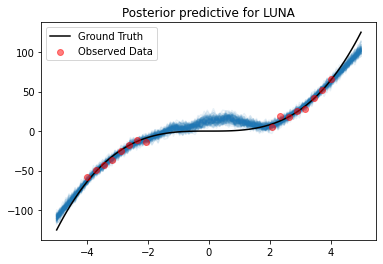

In [57]:
y_posterior = nlm.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape) 

plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")

plt.plot(x_test[0,:], y_posterior.T, color='tab:blue', alpha=0.1,zorder=0)
plt.title('Posterior predictive for NLM')
plt.legend()
plt.show()

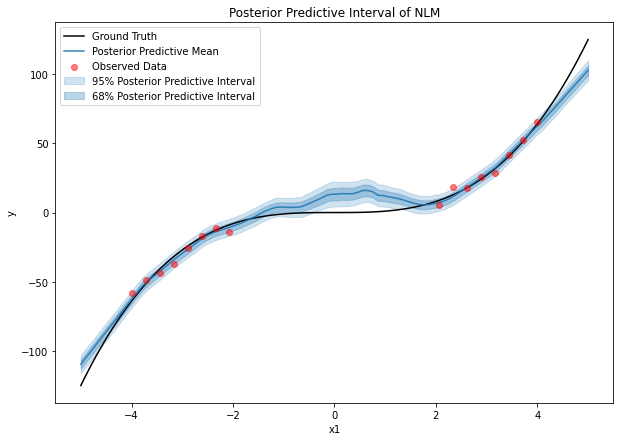

In [58]:
# Calulating percentiles
y_posterior = nlm.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

pp_upper = np.percentile(y_posterior, 97.5, axis=0)
pp_lower = np.percentile(y_posterior, 2.5, axis=0)
pp_upper2 = np.percentile(y_posterior, 84, axis=0)
pp_lower2 = np.percentile(y_posterior, 16, axis=0)
pp_mean = np.mean(y_posterior, axis=0)

# Visualizing 95% posterior predictive interval of Bayesian polynomial regression
plt.figure(figsize=(10,7))
plt.scatter(x_train_slice,y_train_slice,color='r', alpha=0.5,zorder = 100, label='Observed Data')
plt.plot(x_test[0,:],y_test_slice,'k', label="Ground Truth")
plt.plot(x_test[0,:], pp_mean, color='tab:blue', alpha=0.9, label='Posterior Predictive Mean')
plt.fill_between(x_test[0,:], pp_upper, pp_lower, color='tab:blue', alpha=0.2, label='95% Posterior Predictive Interval')
plt.fill_between(x_test[0,:], pp_upper2, pp_lower2, color = 'tab:blue', alpha = 0.3, label = '68% Posterior Predictive Interval')
plt.legend()
plt.xlabel('x1')
plt.ylabel('y')
plt.title("Posterior Predictive Interval of NLM")
plt.show()

In [59]:
# Compute neg_log_likelihood and epistemic uncertainty on training data
y_posterior = nlm.get_posterior_preds(x, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior = y_posterior + np.random.normal(0, noise_var**0.5, size = y_posterior.shape)

print('Negative log likelihood on training data =', neg_log_likelihood(y_posterior, y, noise_var))
print('Epistemic uncertainty on training data = ', epistemic_uncertainty(y_posterior))

Negative log likelihood on training data = 4.934722489404956
Epistemic uncertainty on training data =  3.0922929319499968


In [60]:
# Compute neg_log_likelihood and epistemic uncertainty on test data (gap vs. non-gap)
y_posterior_gap = nlm.get_posterior_preds(x_test_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior_gap = y_posterior_gap + np.random.normal(0, noise_var**0.5, size = y_posterior_gap.shape)


y_posterior_non_gap = nlm.get_posterior_preds(x_test_non_gap, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var, n_models = 5000)
y_posterior_non_gap = y_posterior_non_gap + np.random.normal(0, noise_var**0.5, size = y_posterior_non_gap.shape)


print('Negative log likelihood on test data (gap) =', neg_log_likelihood(y_posterior_gap, y_test_gap, noise_var))
print('Epistemic uncertainty on test data (gap) = ', epistemic_uncertainty(y_posterior_gap))

print('Negative log likelihood on test data (non-gap) =', neg_log_likelihood(y_posterior_non_gap, y_test_non_gap, noise_var))
print('Epistemic uncertainty on test data (non-gap) = ', epistemic_uncertainty(y_posterior_non_gap))

Negative log likelihood on test data (gap) = 20.60174967149181
Epistemic uncertainty on test data (gap) =  3.8561725364429864
Negative log likelihood on test data (non-gap) = 4.48574542071003
Epistemic uncertainty on test data (non-gap) =  3.1296021398799962


# Fit LUNA and NLM with the old data generating function (training data on one slice)

In [61]:
x, y, x_test = generate_data(number_of_points=20, noise_variance=9, input_dimension=2)

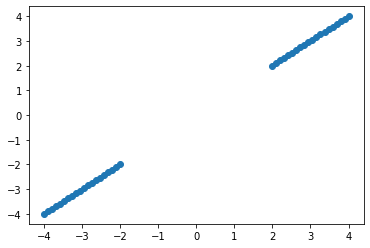

In [62]:
plt.scatter(x[0,:],x[1,:]);

In [63]:
# instantiate an NLM 
nlm2 = NLM(architecture, random=random)
print('Number of parameters =', nlm.D)

params2 = {
    'step_size':1e-2,
    'max_iteration':2000,
    'random_restarts':1,
    'reg_param':10.,
    'lambda_in':1000.
}

nlm2.fit(x,y, params2)

Number of parameters = 2751
Iteration 0 loss 29841.252404262013; gradient mag: 38126.55747872972
Iteration 100 loss 197.7766825269616; gradient mag: 143.89999404369553
Iteration 200 loss 51.3503568319935; gradient mag: 70.74366088551018
Iteration 300 loss 26.959641444906403; gradient mag: 41.2160359080414
Iteration 400 loss 19.84478985184394; gradient mag: 73.41207927250422
Iteration 500 loss 17.76601544666186; gradient mag: 24.668212083686683
Iteration 600 loss 17.026039039332915; gradient mag: 51.129045297255786
Iteration 700 loss 16.581978066158996; gradient mag: 12.636784832216884
Iteration 800 loss 16.3054269118387; gradient mag: 57.28413464118783
Iteration 900 loss 15.91452364767078; gradient mag: 76.2757467423963
Iteration 1000 loss 15.587198116422218; gradient mag: 14.202015426132917
Iteration 1100 loss 15.522158936012005; gradient mag: 41.493077561599165
Iteration 1200 loss 15.393308117981842; gradient mag: 54.12006231051764
Iteration 1300 loss 15.296143911391116; gradient mag

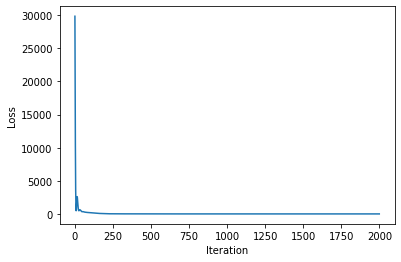

In [64]:
plt.plot(nlm2.objective_trace)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

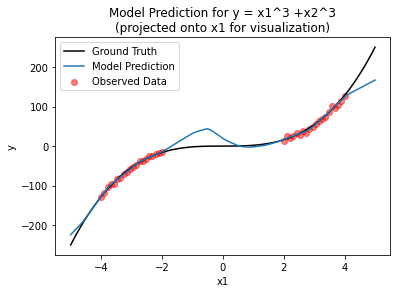

In [65]:
y_pred = nlm2.forward(nlm2.weights, x_test)
plt.scatter(x[0,:], y.flatten(), color='red', alpha=0.5, label='Observed Data')
plt.plot(x_test[0,:], np.sum(x_test**3, axis=0), color='black', label="Ground Truth")
plt.plot(x_test[0,:], y_pred.flatten(), color='tab:blue', label="Model Prediction")
plt.xlabel("x1")
plt.ylabel("y")
plt.title("Model Prediction for y = x1^3 +x2^3\n(projected onto x1 for visualization)")
plt.legend()
plt.show()

In [66]:
prior_mean = 0
prior_var = 9.
# noise_var = 9.

y_prior = nlm2.get_prior_preds(x_test, w_prior_mean=prior_mean, w_prior_cov=prior_var, noise_var=noise_var)

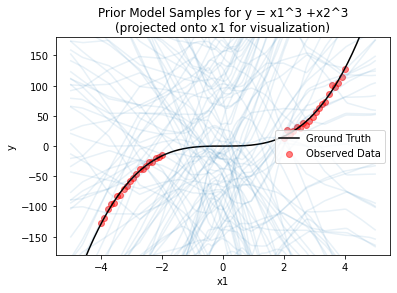

In [67]:
plt.scatter(x[0,:], y.flatten(), color='red', alpha=0.5, label='Observed Data')
plt.plot(x_test[0,:], np.sum(x_test**3, axis=0), color='black', label="Ground Truth")
plt.plot(x_test[0,:], y_prior.T, color='tab:blue', alpha=0.1)
plt.ylim([-180, 180])
plt.xlabel("x1")
plt.ylabel("y")
plt.title("Prior Model Samples for y = x1^3 +x2^3\n(projected onto x1 for visualization)")
plt.legend()
plt.show()

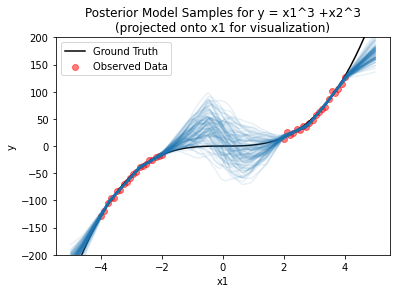

In [68]:
y_posterior = nlm2.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)
plt.scatter(x[0,:], y.flatten(), color='red', alpha=0.5, label='Observed Data')
plt.plot(x_test[0,:], np.sum(x_test**3, axis=0), color='black', label="Ground Truth")
plt.plot(x_test[0,:], y_posterior.T, color='tab:blue', alpha=0.1)
plt.ylim([-200, 200])
plt.xlabel("x1")
plt.ylabel("y")
plt.title("Posterior Model Samples for y = x1^3 +x2^3\n(projected onto x1 for visualization)")
plt.legend()
plt.show()

In [69]:
# instantiate LUNA with same architecture 
luna2 = LUNA(architecture, random=random)
print('Number of parameters =', luna2.D)

luna2.fit(x,y, params2)

Number of parameters = 5250
Iteration 0 loss 14623.112283148957; gradient mag: 6335.36429783838
Iteration 100 loss 776.422614783522; gradient mag: 47.7045551964112
Iteration 200 loss 539.9162959711769; gradient mag: 29.175318721886363
Iteration 300 loss 519.4748584015043; gradient mag: 105.11811323277249
Iteration 400 loss 516.0542744200678; gradient mag: 27.6007213672387
Iteration 500 loss 514.4829288729634; gradient mag: 36.480245802411716
Iteration 600 loss 513.8085263423326; gradient mag: 61.618525227763676
Iteration 700 loss 512.11106246156; gradient mag: 55.49683626827955
Iteration 800 loss 510.5705689047187; gradient mag: 52.60572136731212
Iteration 900 loss 509.7255210621167; gradient mag: 40.14259077641856
Iteration 1000 loss 509.168496210871; gradient mag: 22.043105253222976
Iteration 1100 loss 510.8238692420768; gradient mag: 52.18776097977305
Iteration 1200 loss 509.0133600311005; gradient mag: 48.212925634662255
Iteration 1300 loss 508.5721837976874; gradient mag: 23.83865

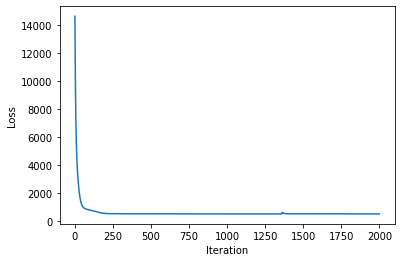

In [70]:
plt.plot(luna2.objective_trace)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.show()

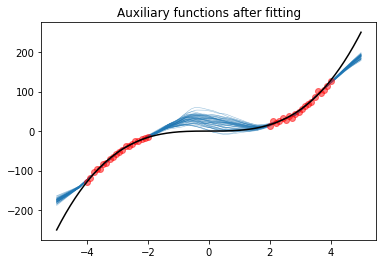

In [71]:
y_pred = luna2.forward(luna2.weights, x_test)
np.squeeze(y_pred).T.shape, x_test[0,:].T.shape

plt.scatter(x[0,:], y.flatten(), color='red', alpha=0.5, label='Observed Data')
plt.plot(x_test[0,:], np.sum(x_test**3, axis=0), color='black', label="Ground Truth")
plt.plot(x_test[0,:].T, np.squeeze(y_pred).T, color='tab:blue',linewidth = 0.5, alpha=0.5, zorder = 0)
plt.title('Auxiliary functions after fitting')
plt.show()


In [72]:
prior_mean = 0
prior_var = 9.
# noise_var = 9.

y_prior = luna2.get_prior_preds(x_test, w_prior_mean=prior_mean, w_prior_cov=prior_var, noise_var=noise_var)


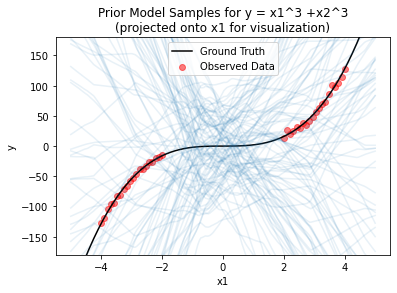

In [73]:
plt.scatter(x[0,:], y.flatten(), color='red', alpha=0.5, label='Observed Data')
plt.plot(x_test[0,:], np.sum(x_test**3, axis=0), color='black', label="Ground Truth")
plt.plot(x_test[0,:], y_prior.T, color='tab:blue', alpha=0.1)
plt.ylim([-180, 180])
plt.xlabel("x1")
plt.ylabel("y")
plt.title("Prior Model Samples for y = x1^3 +x2^3\n(projected onto x1 for visualization)")
plt.legend()
plt.show()

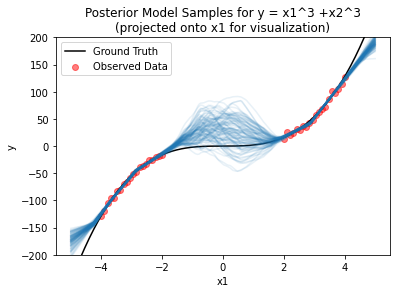

In [74]:
y_posterior = luna2.get_posterior_preds(x_test, x_obs=x, y_obs=y, w_prior_cov=prior_var, noise_var=noise_var)

plt.scatter(x[0,:], y.flatten(), color='red', alpha=0.5, label='Observed Data')
plt.plot(x_test[0,:], np.sum(x_test**3, axis=0), color='black', label="Ground Truth")
plt.plot(x_test[0,:], y_posterior.T, color='tab:blue', alpha=0.1)
plt.ylim([-200, 200])
plt.xlabel("x1")
plt.ylabel("y")
plt.title("Posterior Model Samples for y = x1^3 +x2^3\n(projected onto x1 for visualization)")
plt.legend()
plt.show()